# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

/Users/haimo/Documents/study/DL/.venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []
        self.sentences = []
        self.token_freq = {}
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1 - np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("../data/stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
runs ['doze', 'minutes', 'concession', 'stand']
variety ['you', 'it', 'visit']
less ['college', 'entrance']
hardest ['strikes', 'how', 'dynamics']
benign ['leukemia', 'shimmering']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [3]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts: int = 30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_tokens = data.num_tokens()
        self.num_contexts = num_contexts
        self.context_lenght = 5
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = []
        for _ in range(self.num_contexts):
            center_word, other_words = self.data.get_random_context(self.context_lenght)

            input_idx = self.data.index_by_token[center_word]
            out_indexes = [self.data.index_by_token[word] for word in other_words]
            
            self.samples.extend([(input_idx, out_idx) for out_idx in out_indexes])

    def __len__(self) -> int:
        '''
        Returns total number of samples
        '''
        return len(self.samples)
    
    def __getitem__(self, index: int):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        in_idx, out_idx = self.samples[index]
        in_idx = torch.nn.functional.one_hot(torch.tensor([in_idx]), self.data.num_tokens()).T

        return in_idx, out_idx

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]

print(f"Sample - input: {input_vector}, target: {int(target)}") # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]), target: 1216


# Создаем модель и тренируем ее

In [32]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [33]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    return nn_model[0].weight.T, nn_model[1].weight

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [6]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch

        loss_accum = correct_samples = total_samples = 0
        for step, (x, y) in enumerate(train_loader):
            x = x.to(torch.float32)
            y = y.type(torch.LongTensor)
            pred = model(x.reshape(x.shape[0], -1))
            # pred = model(x)
            loss_value = loss(pred, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(pred, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value
        
        scheduler.step()

        ave_loss = loss_accum / step
        train_accuracy = correct_samples / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [111]:
from collections import namedtuple

Hyperparams = namedtuple("Hyperparams", ['batch_size', 'learning_rate', 'momentum', 'weight_decay', 'anneal_epochs', 'anneal_coeff'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'loss_history'])
run_record = {}

In [ ]:
# Finally, let's train the model!
batch_size = 50
anneal_epochs=10
anneal_coeff=0.1
lr_list=[1e-1, 1e-3, 1e-5]
weight_decay=[1e-2, 1e-4, 1e-6]
momentum = [0, 0.9, 0.99]
epochs=3

for lr in lr_list:
    for m in momentum:
        for wd in weight_decay:
            params = Hyperparams(batch_size, lr, m, wd, anneal_epochs, anneal_coeff)
            print(params)

            nn_model = nn.Sequential(
                nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
                nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
            )
            nn_model.type(torch.FloatTensor)
            
            optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=wd, momentum=m)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
            train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
            
            loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, epochs)
            run_record[params] = RunResult(nn_model, train_history, loss_history)

In [ ]:
batch_size = 50
anneal_epochs=10
anneal_coeff=0.1
lr_list=[1e-1, 1e-3, 1e-5]
weight_decay=[1e-2, 1e-4, 1e-6]
momentum = [0, 0.9, 0.99]
epochs=3

for lr in lr_list:
    for wd in weight_decay:
        params = Hyperparams(batch_size, lr, m, wd, anneal_epochs, anneal_coeff)
        print(params)

        nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
        )
        nn_model.type(torch.FloatTensor)
        
        optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        
        loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, epochs)
        run_record[params] = RunResult(nn_model, train_history, loss_history)

Hyperparams(batch_size=50, learning_rate=0.1, momentum=0, weight_decay=0.01, anneal_epochs=10, anneal_coeff=0.1)
Epoch 0, Average loss: 9.885894, Train accuracy: 0.000169
Epoch 1, Average loss: 9.885934, Train accuracy: 0.000036
Epoch 2, Average loss: 9.885946, Train accuracy: 0.000109
Hyperparams(batch_size=50, learning_rate=0.1, momentum=0, weight_decay=0.0001, anneal_epochs=10, anneal_coeff=0.1)
Epoch 0, Average loss: 10.198336, Train accuracy: 0.000205
Epoch 1, Average loss: 10.465687, Train accuracy: 0.000157
Epoch 2, Average loss: 10.388401, Train accuracy: 0.000109
Hyperparams(batch_size=50, learning_rate=0.1, momentum=0, weight_decay=1e-06, anneal_epochs=10, anneal_coeff=0.1)
Epoch 0, Average loss: 15.291681, Train accuracy: 0.000229
Epoch 1, Average loss: 20.078987, Train accuracy: 0.000157
Epoch 2, Average loss: 18.396555, Train accuracy: 0.000133
Hyperparams(batch_size=50, learning_rate=0.1, momentum=0.9, weight_decay=0.01, anneal_epochs=10, anneal_coeff=0.1)
Epoch 0, Averag

/var/folders/wd/_fgjf67n0rlgd1_0pyytpbd00000gn/T/ipykernel_18279/3272821117.py:5: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(run_result.train_history, label=hyperparams)
/var/folders/wd/_fgjf67n0rlgd1_0pyytpbd00000gn/T/ipykernel_18279/3272821117.py:9: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(run_result.loss_history, label=hyperparams)


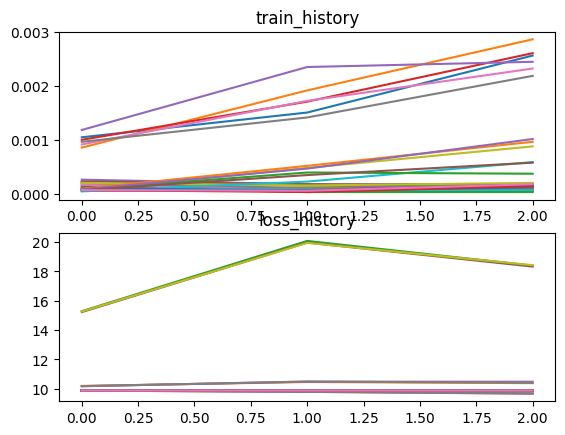

In [ ]:
# Visualize training graphs
for hyperparams, run_result in run_record.items():
    plt.subplot(211)
    plt.title('train_history')
    plt.plot(run_result.train_history, label=hyperparams)

    plt.subplot(212)
    plt.title('loss_history')
    plt.plot(run_result.loss_history, label=hyperparams)

loss: 9.8841,
accuracy: 0.0026,
params: Hyperparams(batch_size=50, learning_rate=0.001, momentum=0, weight_decay=0.0001, anneal_epochs=10, anneal_coeff=0.1)

loss: 9.6730,
accuracy: 0.0029,
params: Hyperparams(batch_size=50, learning_rate=0.001, momentum=0, weight_decay=1e-06, anneal_epochs=10, anneal_coeff=0.1)

loss: 9.8844,
accuracy: 0.0026,
params: Hyperparams(batch_size=50, learning_rate=0.001, momentum=0.9, weight_decay=0.0001, anneal_epochs=10, anneal_coeff=0.1)

loss: 9.6779,
accuracy: 0.0024,
params: Hyperparams(batch_size=50, learning_rate=0.001, momentum=0.9, weight_decay=1e-06, anneal_epochs=10, anneal_coeff=0.1)

loss: 9.8841,
accuracy: 0.0023,
params: Hyperparams(batch_size=50, learning_rate=0.001, momentum=0.99, weight_decay=0.0001, anneal_epochs=10, anneal_coeff=0.1)

loss: 9.6966,
accuracy: 0.0022,
params: Hyperparams(batch_size=50, learning_rate=0.001, momentum=0.99, weight_decay=1e-06, anneal_epochs=10, anneal_coeff=0.1)

loss: 9.8860,
accuracy: 0.0010,
params: Hyper

/var/folders/wd/_fgjf67n0rlgd1_0pyytpbd00000gn/T/ipykernel_18279/3504662310.py:12: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(res, label=params)


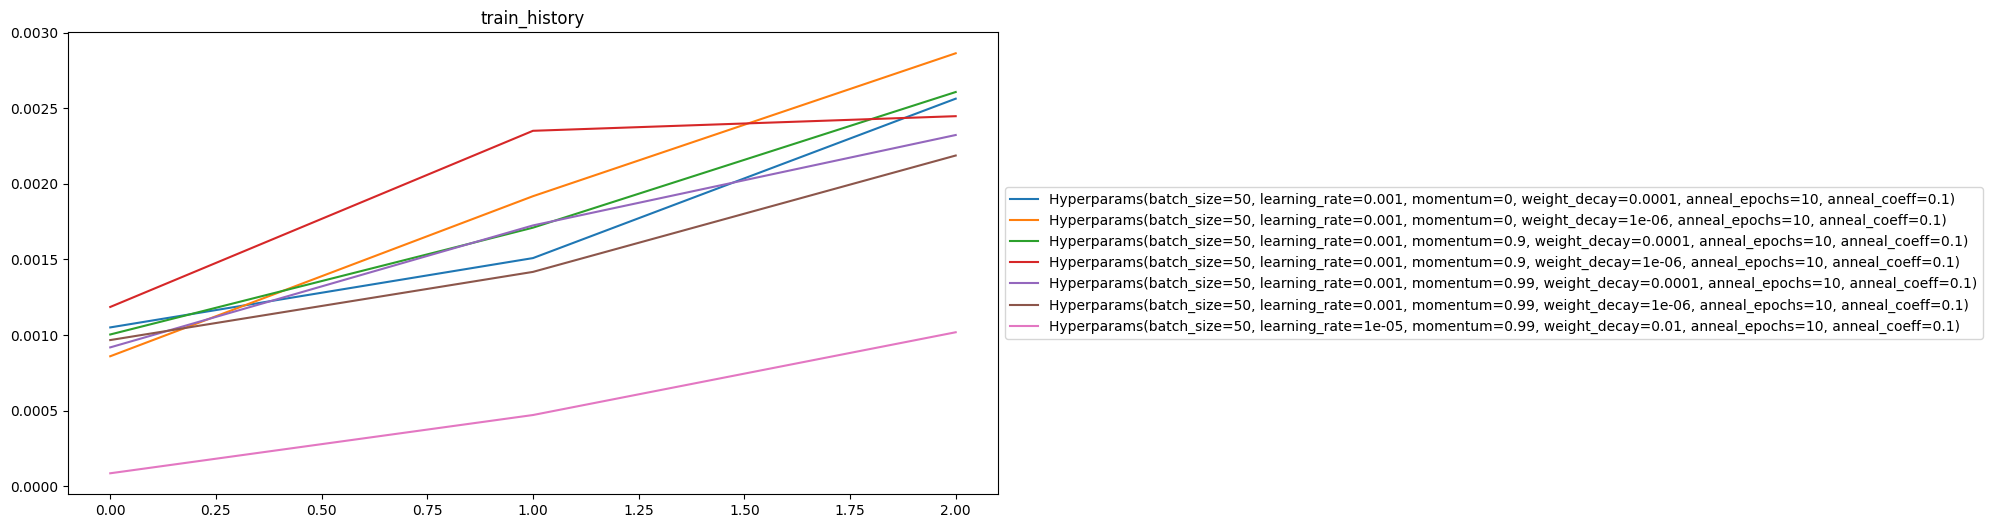

In [ ]:
results_to_display = []
for hyperparams, run_result in run_record.items():
    if run_result.train_history[-1] > 0.001:
        results_to_display.append((run_record[hyperparams].train_history, hyperparams))
        print(f"loss: {run_result.loss_history[-1]:.4f},\naccuracy: {run_result.train_history[-1]:.4f},\nparams: {hyperparams}\n")
        
# Visualize training graphs
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(111)
plt.title('train_history')
for res, params in results_to_display:
    ax.plot(res, label=params)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

train best model

In [7]:
# best_model = run_record[Hyperparams(batch_size=50, learning_rate=0.001, momentum=0.99, weight_decay=1e-06, anneal_epochs=10, anneal_coeff=0.1)].model

best_model = nn.Sequential(
    nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
    nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
)
best_model.type(torch.FloatTensor)

Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [11]:
batch_size=60
learning_rate=0.01
weight_decay=1e-08
anneal_epochs=30
anneal_coeff=0.1
epochs=50

optimizer = optim.Adam(best_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

loss_history, train_history = train_model(best_model, dataset, train_loader, optimizer, scheduler, epochs)

Epoch 0, Average loss: 9.170517, Train accuracy: 0.010502
Epoch 1, Average loss: 9.240038, Train accuracy: 0.009151
Epoch 2, Average loss: 9.047270, Train accuracy: 0.011030
Epoch 3, Average loss: 8.899916, Train accuracy: 0.012794
Epoch 4, Average loss: 8.780108, Train accuracy: 0.013809
Epoch 5, Average loss: 8.687302, Train accuracy: 0.016184
Epoch 6, Average loss: 8.594985, Train accuracy: 0.017486
Epoch 7, Average loss: 8.543398, Train accuracy: 0.018846
Epoch 8, Average loss: 8.466361, Train accuracy: 0.019873
Epoch 9, Average loss: 8.447998, Train accuracy: 0.020452
Epoch 10, Average loss: 8.415803, Train accuracy: 0.020931
Epoch 11, Average loss: 8.365015, Train accuracy: 0.022173
Epoch 12, Average loss: 8.337694, Train accuracy: 0.022194
Epoch 13, Average loss: 8.325095, Train accuracy: 0.022309
Epoch 14, Average loss: 8.292763, Train accuracy: 0.024533
Epoch 15, Average loss: 8.279850, Train accuracy: 0.024143
Epoch 16, Average loss: 8.272387, Train accuracy: 0.024655
Epoch 1

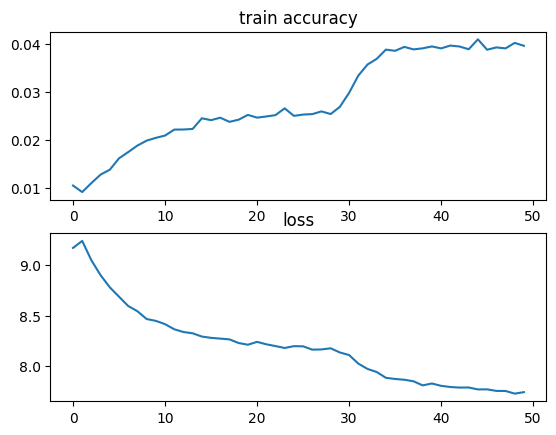

In [12]:
plt.subplot(211)
plt.title('train accuracy')
plt.plot(train_history)
# plt.plot(x=range(len(train_history)), y=train_history)

plt.subplot(212)
plt.title('loss')
plt.plot(loss_history)
# plt.plot(x=range(len(loss_history)), y=loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

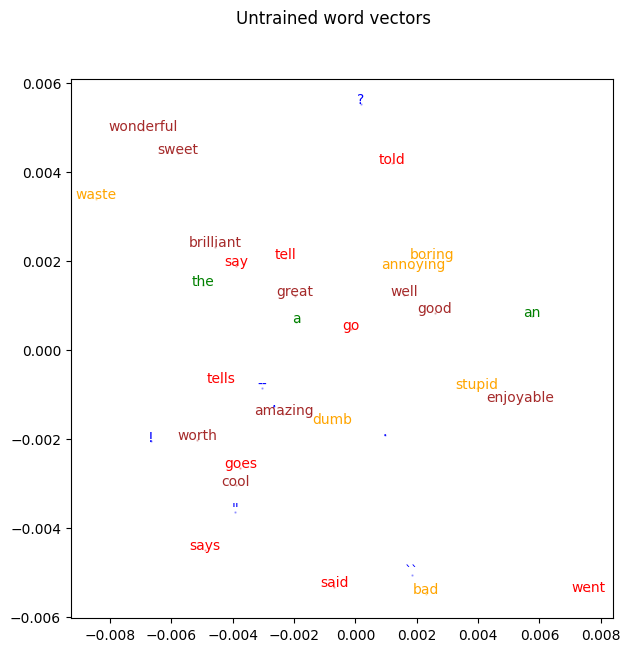

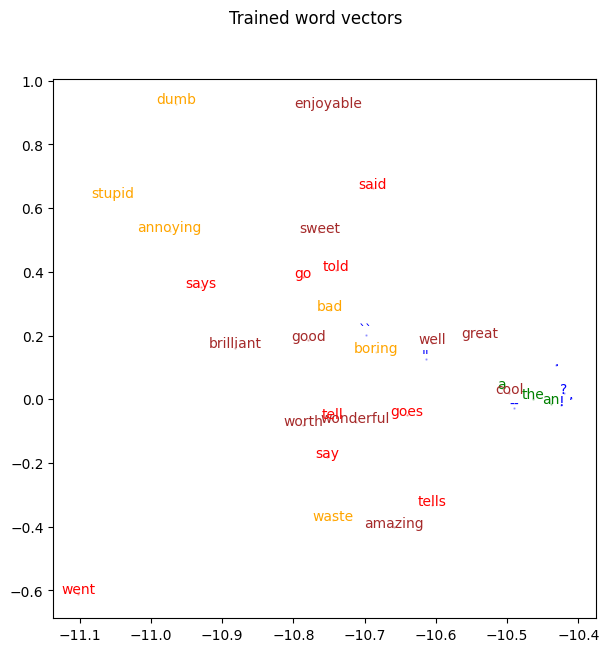

In [35]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(best_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")